# Average elemental stress on a given volume {#ref_volume_averaged_stress_advanced}

This example shows how to find the minimum list of surrounding elements
for a given node to get a minimum volume. For each list of elements, the
elemental stress equivalent is multiplied by the volume of each element.
This result is then accumulated to divide it by the total volume.


In [1]:
from ansys.dpf import core as dpf
from ansys.dpf.core import examples
from ansys.dpf.core import operators as ops

# Create a model targeting a given result file

The model provides easy access to the mesh and time frequency support.


In [2]:
model = dpf.Model(examples.find_complex_rst())
mesh = model.metadata.meshed_region

# Volume size to check
volume_check = 4.0e-11

# Get all node IDs in the model to find the minimum amount of
# surrounding elements to get a minimum volume.
nodes = mesh.nodes.scoping
nodes_ids = nodes.ids
nodes_ids_to_compute = []
for i in range(0, 400):
    nodes_ids_to_compute.append(nodes_ids[i])
elements = mesh.elements.scoping
elements_ids = elements.ids

# Read the volume by element


In [3]:
vol_op = ops.result.elemental_volume()
vol_op.inputs.streams_container(model.metadata.streams_provider)
vol_field = vol_op.outputs.fields_container()[0]

# Find the minimum list of elements by node to get the volume check


In [4]:
# get the connectivity and inverse connectivity fields
connectivity_field = mesh.elements.connectivities_field
nodal_connectivity_field = mesh.nodes.nodal_connectivity_field

node_index_to_el_ids = {}
node_index_to_found_volume = {}
# using the with statement with as_local_field allows to bring the server's
# data locally and to work only on the local process before sending the data
# updates to the server as the end of the with statement
# the performances are a lot better using this syntax
# fmt: off
with connectivity_field.as_local_field() as connectivity, \
    nodal_connectivity_field.as_local_field() as nodal_connectivity,\
        vol_field.as_local_field() as vol:  # fmt: on
    for i, node in enumerate(nodes_ids_to_compute):

        current_node_indexes = [i]
        volume = 0.0
        # Loop through recursively selecting elements attached
        # to nodes until specified volume is reached
        while volume_check > volume:
            volume = 0.0
            elements_indexes = []

            # Get elements attached to nodes
            for current_node_index in current_node_indexes:
                elements_indexes.extend(nodal_connectivity.get_entity_data(i).flatten())

            current_node_indexes = []
            for index in elements_indexes:
                # Sum up the volume on those elements
                volume += vol.get_entity_data(index)[0]
                # Get all nodes of the current elements for next iteration
                current_node_indexes.extend(connectivity.get_entity_data(index))

        node_index_to_el_ids[i] = [elements_ids[index] for index in elements_indexes]
        node_index_to_found_volume[i] = volume

# Create workflow

For each list of elements surrounding nodes:

-   Compute equivalent stress averaged on elements.
-   Apply dot product seqv.volume.
-   Sum up those on the list of elements.
-   Divide this sum by the total volume on these elements.


In [5]:
s = model.results.stress()
to_elemental = ops.averaging.to_elemental_fc(s)
eqv = ops.invariant.von_mises_eqv_fc(to_elemental)
values_to_sum_field = eqv.outputs.fields_container()[0]

# sum up the seqv by list of elements and create a Field
seqvsum = dpf.fields_factory.create_scalar_field(len(nodes), dpf.locations.nodal)
dataseqvsum = []
volsum = dpf.fields_factory.create_scalar_field(len(nodes), dpf.locations.nodal)
datavolsum = []

with values_to_sum_field.as_local_field() as values_to_sum:
    with vol_field.as_local_field() as vol:
        for key in node_index_to_el_ids:
            ssum = 0.0
            for id in node_index_to_el_ids[key]:
                ssum += (
                    values_to_sum.get_entity_data_by_id(id)[0] * vol.get_entity_data_by_id(id)[0]
                )
            dataseqvsum.append(ssum)
            datavolsum.append(node_index_to_found_volume[key])

seqvsum.data = dataseqvsum
seqvsum.scoping.ids = nodes_ids_to_compute

volsum.data = datavolsum
volsum.scoping.ids = nodes_ids_to_compute

# use component wise divide to average the stress by the volume
divide = ops.math.component_wise_divide(seqvsum, volsum)
divide.run()

# Plot equivalent elemental stress and volume averaged elemental equivalent stress


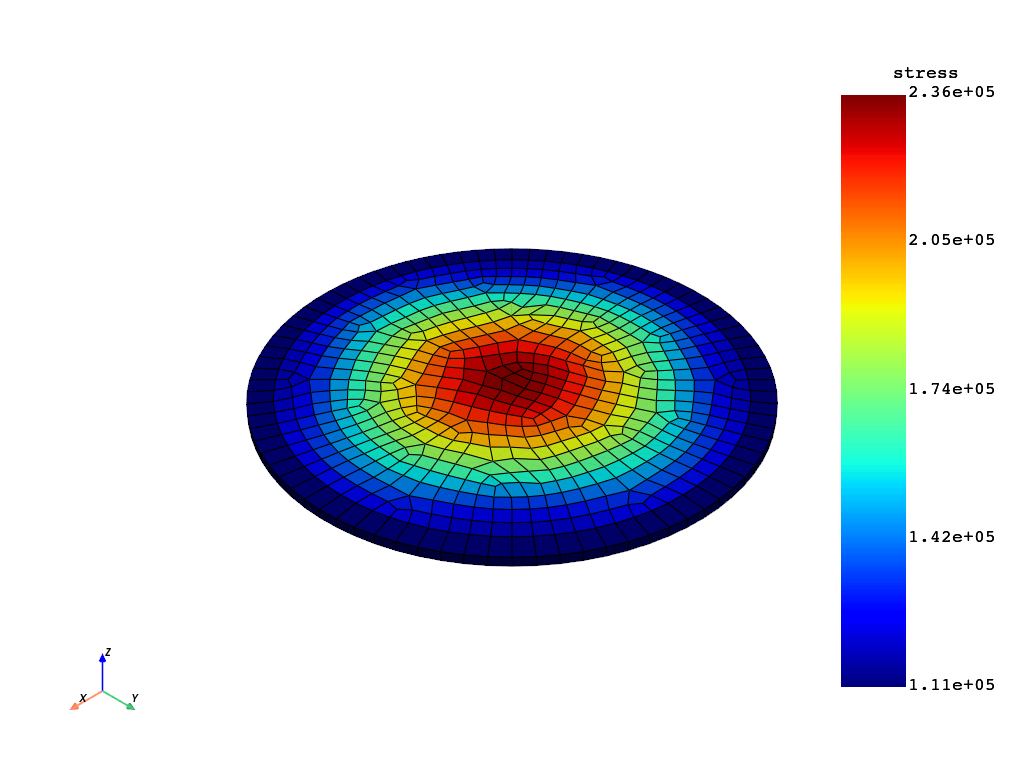

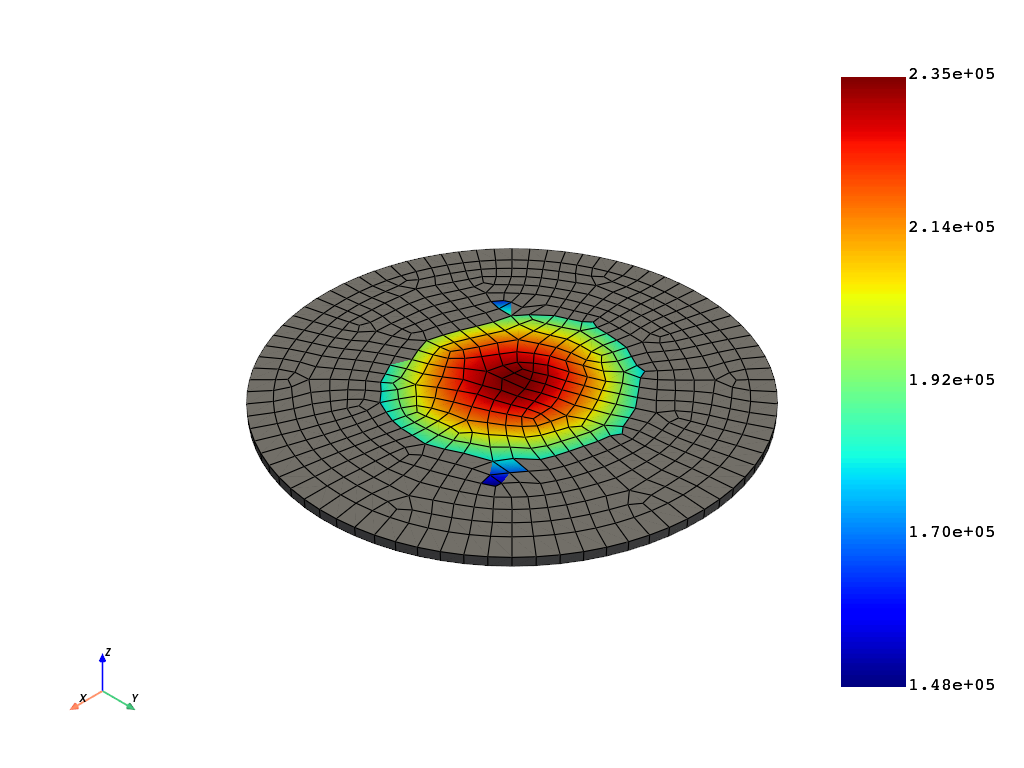

In [6]:
mesh.plot(values_to_sum_field)
mesh.plot(divide.outputs.field())

# Use the operator instead

An operator with the same algorithm has been implemented


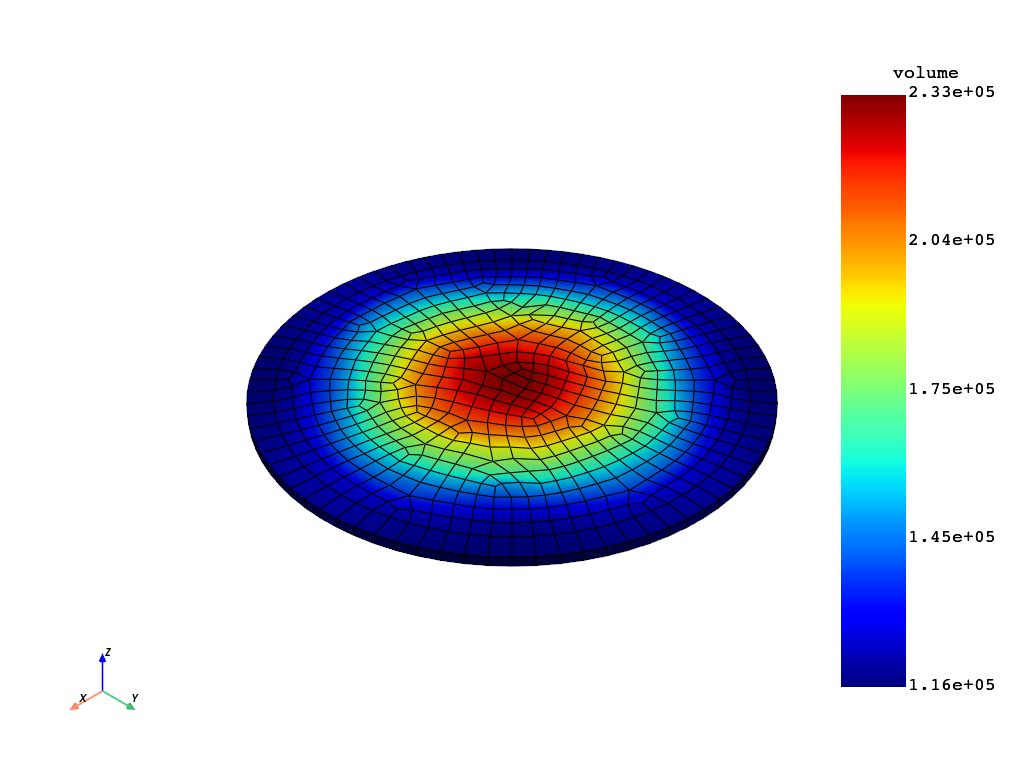

In [7]:
s_fc = s.outputs.fields_container()
single_field_vol_fc = dpf.fields_container_factory.over_time_freq_fields_container([vol_field])

single_field_fc = dpf.fields_container_factory.over_time_freq_fields_container(
    [values_to_sum_field]
)

op = dpf.Operator("volume_stress")
op.inputs.scoping.connect(nodes)
op.inputs.stress_fields.connect(single_field_fc)
op.inputs.volume_fields(single_field_vol_fc)
op.inputs.volume(volume_check * 10.0)

out = op.get_output(0, dpf.types.field)
mesh.plot(out)